In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib as jb
import seaborn as sns
%matplotlib inline

In [2]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import cufflinks as cf
import plotly.express as px
from plotly.offline import iplot
import plotly as py
cf.go_offline()
py.offline.init_notebook_mode(connected=True)
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot

In [87]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

In [4]:
house = pd.read_csv('C:\PYTHON\Bangalore_house_price\Data\Train.csv')

In [5]:
house.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

## Handling Missing data

In [6]:
def met_ya(x):
    spt = x.split('Sq. ')
    if 'Meter' in spt:
        con_me = float(spt[0])*10.7639
        return np.NaN
    elif 'Yards' in spt:
        con_ya = float(spt[0])*9
        return np.NaN
    elif 'Perch' in x:
        per = x.split('Perch')
        con_per = float(per[0])*272.25
        return np.NaN
    elif 'Acres' in x:
        acr = x.split('Acres')
        con_acr = float(acr[0])*43560
        return np.NaN
    elif 'Guntha' in x :
        gun = x.split('Guntha')
        con_gun = float(gun[0])*1089
        return np.NaN
    elif 'Cents' in x:
        cen = x.split('Cents')
        con_cen = float(cen[0])*435.55999997
        return np.NaN
    elif 'Grounds' in x:
        gro = x.split('Grounds')
        con_gro = float(gro[0])*2400.352024
        return np.NaN
    else:
        spt2 = x.split()
        if '-' in spt2:
            m = (float(spt2[0])+float(spt2[2]))/2
            return m
        else:
            return float(x)

In [7]:
house.dropna(subset=['size','location','bath'],inplace = True)

In [8]:
house['size'] = house['size'].apply(lambda x: float(x.split()[0]))

In [9]:
house.drop(labels=['area_type','society','availability','balcony'],axis = 1,inplace = True)
# these labels are not important factors for determing the price
# size,bath,location ,total_sqft are the important factor for determining the price

In [10]:
house.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [11]:
house['total_sqft'] = house['total_sqft'].apply(lambda x: met_ya(x))
# I converted range values in total sqft to mean of min and max
# I removed data which are in another form of measurement unit
# because they are creating more errors and outlier in our data

In [12]:
house.dropna(subset=['total_sqft'],inplace = True)

In [13]:
house.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2.0,1056.0,2.0,39.07
1,Chikka Tirupathi,4.0,2600.0,5.0,120.00
2,Uttarahalli,3.0,1440.0,2.0,62.00
3,Lingadheeranahalli,3.0,1521.0,3.0,95.00
4,Kothanur,2.0,1200.0,2.0,51.00


# Cleaning Outliers and Error in Data

In [14]:
# house.drop_duplicates(inplace = True)

In [15]:
from scipy.stats import zscore # removing outliers using zscore

In [16]:
house['size_zscore'] = zscore(house['size'].values) 

In [17]:
house[(house['size_zscore'].abs() <=3)]

,location,size,total_sqft,bath,price,size_zscore
0,Electronic City Phase II,2.0,1056.0,2.0,39.07,-0.619459
1,Chikka Tirupathi,4.0,2600.0,5.0,120.00,0.927577
2,Uttarahalli,3.0,1440.0,2.0,62.00,0.154059
3,Lingadheeranahalli,3.0,1521.0,3.0,95.00,0.154059
4,Kothanur,2.0,1200.0,2.0,51.00,-0.619459
...,...,...,...,...,...,...
13315,Whitefield,5.0,3453.0,4.0,231.00,1.701095
13316,Richards Town,4.0,3600.0,5.0,400.00,0.927577
13317,Raja Rajeshwari Nagar,2.0,1141.0,2.0,60.00,-0.619459
13318,Padmanabhanagar,4.0,4689.0,4.0,488.00,0.927577


In [18]:
house['total_sqft_zscore'] = zscore(house['total_sqft'].values)
house['bath_zscore'] = zscore(house['bath'].values)

In [19]:
house2 = house[(house['size_zscore'].abs() <= 3) & (house['total_sqft_zscore'].abs() <= 3) & (house['bath_zscore'].abs() <= 3)]

C:\PYTHON\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

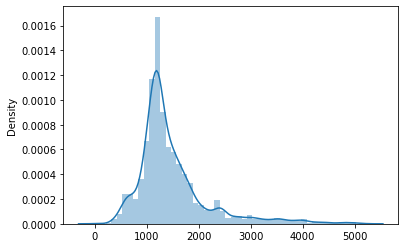

In [20]:
sns.distplot(x = house2['total_sqft'])

C:\PYTHON\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

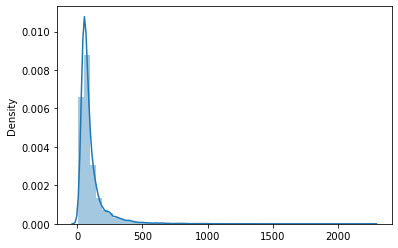

In [21]:
sns.distplot(x = house2['price']) # this data is more skewed

<AxesSubplot:xlabel='size'>

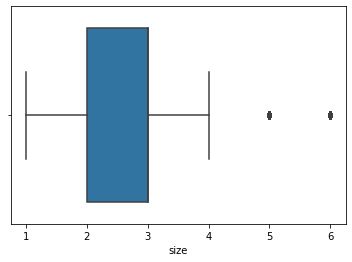

In [22]:
sns.boxplot(x = 'size',data = house2)

In [23]:
house2.shape

(12797, 8)

In [24]:
house2[(house2['size'] >5) & (house2['total_sqft'] <800)].index
# more the 5bhk in 800 sqft is little ambiguous
# so i removed these data

Int64Index([   89,   397,   789,  1624,  1769,  3685,  4576,  4589,  5965,
             6486,  6818,  8005,  9636,  9862, 10005, 10280, 10536, 11179,
            11244, 12942, 13023, 13045],
           dtype='int64')

In [25]:
house2.shape

(12797, 8)

In [26]:
fil = house2.drop(index = house2[(house2['size'] >5) & (house2['total_sqft'] <800)].index)

In [27]:
fil.shape

(12775, 8)

In [28]:
fil[(fil['total_sqft'] < 400)].index #at least 400 sqft need for 1bhk

Int64Index([  119,   349,   504,   992,  1020,  1122,  1471,  2041,  2437,
             2486,  2557,  3741,  4086,  4853,  5970,  6179,  6586,  7616,
             7724,  8494,  8517,  8545,  8890, 10526, 11495, 11558, 12464,
            13216],
           dtype='int64')

In [29]:
fil.drop(index=list(fil[(fil['total_sqft'] < 300)].index),inplace=True)

In [30]:
fil.shape

(12765, 8)

In [31]:
fil.head()

,location,size,total_sqft,bath,price,size_zscore,total_sqft_zscore,bath_zscore
0,Electronic City Phase II,2.0,1056.0,2.0,39.07,-0.619459,-0.403550,-0.516211
1,Chikka Tirupathi,4.0,2600.0,5.0,120.00,0.927577,0.844352,1.724494
2,Uttarahalli,3.0,1440.0,2.0,62.00,0.154059,-0.093191,-0.516211
3,Lingadheeranahalli,3.0,1521.0,3.0,95.00,0.154059,-0.027724,0.230691
4,Kothanur,2.0,1200.0,2.0,51.00,-0.619459,-0.287165,-0.516211


In [32]:
fil2 = fil.copy()

In [33]:
fil2['location'] = fil2['location'].apply(lambda x: x.strip())
fil2.location 

0        Electronic City Phase II
1                Chikka Tirupathi
2                     Uttarahalli
3              Lingadheeranahalli
4                        Kothanur
                   ...           
13315                  Whitefield
13316               Richards Town
13317       Raja Rajeshwari Nagar
13318             Padmanabhanagar
13319                Doddathoguru
Name: location, Length: 12765, dtype: object

In [34]:
sick = pd.DataFrame(fil2.location.value_counts()) 

In [35]:
def maping(x):
    if x in sick[sick['location'] <= 10].index.values:
        return 'otherlocation'
    else:
        return x

In [36]:
fil2['location'] = fil2['location'].apply(lambda x: maping(x))
# if count of any location is less than or equal to 10
# i changed location name to other location 
# bcz they are not help much help full for model
#it have more than 1000 categories it is hard for model

In [37]:
fil2['price_per_sqft'] = fil2['price']*100000/fil2['total_sqft'] # price per sqft in lakhs

In [38]:
fil2.shape

(12765, 9)

##### in same location price per sqft is 2bhk is less than 1bhk that data should have error so removed these data

In [39]:
def own_out(data):
    import itertools
    ut_index = []
    gp_loc = data.groupby(['location','size']).mean().reset_index()
    gp_count = data.groupby(['location','size']).count().reset_index()['price_per_sqft']
    gp_loc['count'] = gp_count
    for loc in data['location'].unique():
        size_val = {}
        for size ,mean,count in gp_loc[gp_loc['location'] == loc][['size','price_per_sqft','count']].values:
            size_val[size] = {
                'loc' : loc,
                'mean' : mean,
                'count' : count
            }
        for size ,mean,count in gp_loc[gp_loc['location'] == loc][['size','price_per_sqft','count']].values:
            dt = size-1
            if dt in size_val:
                p = size_val[dt]
                if p['count'] > 5:
                    temp = fil2[(fil2['location'] == loc)&(fil2['size'] == size)]
                    ut_index.append(list(temp[temp['price_per_sqft'] < p['mean']].index.values))
    flatten = list(itertools.chain(*ut_index)) # reduce  the dimension
    return data.drop(index = flatten)

In [40]:
fil2 = own_out(fil2)

In [41]:
fil2.shape

(8836, 9)

# EDA

<AxesSubplot:>

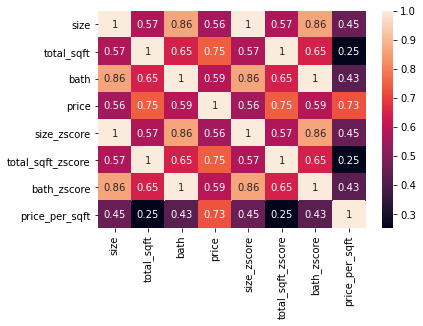

In [42]:
sns.heatmap(fil2.corr(),annot=True) # size and bath are highly correlated

In [43]:
lo_gby = fil2.groupby('location').mean().sort_values(by = 'price',ascending=False).reset_index()

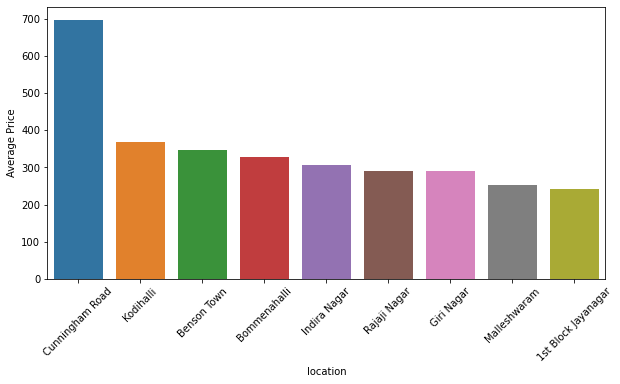

In [44]:
plt.figure(figsize=(10,5)) # top ten location - high house_price range
sns.barplot(x = 'location',y = 'price',data = lo_gby.head(9))
plt.xticks(rotation = 45)
plt.ylabel('Average Price')
plt.show()

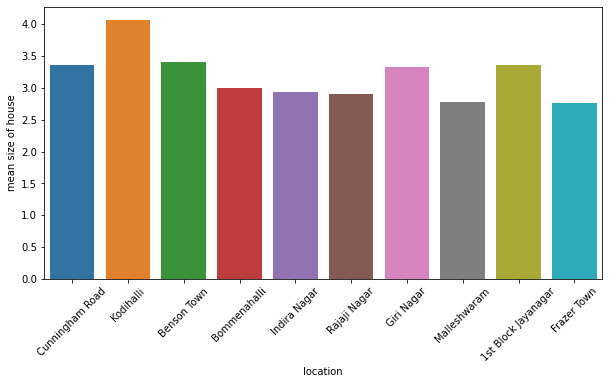

In [45]:
plt.figure(figsize=(10,5))  
sns.barplot(x = 'location',y = 'bath',data = lo_gby.head(10))
plt.xticks(rotation = 45)
plt.ylabel('mean size of house')
plt.show()

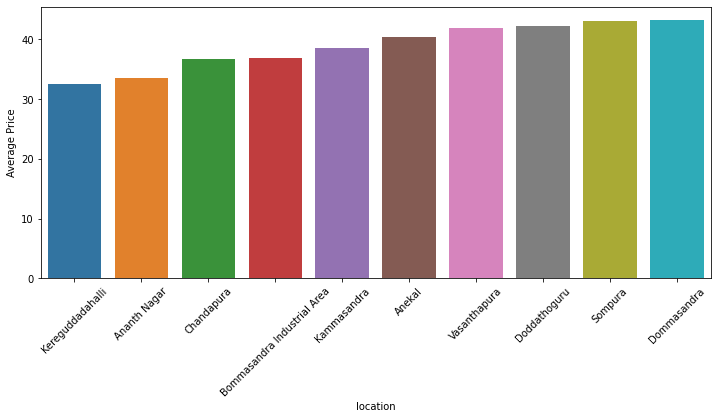

In [46]:
plt.figure(figsize=(12,5)) #top location -have least or low house_price
sns.barplot(x = 'location',y = 'price',data = lo_gby.sort_values(by = 'price').head(10))
plt.xticks(rotation = 45)
plt.ylabel('Average Price')
plt.show()

<AxesSubplot:>

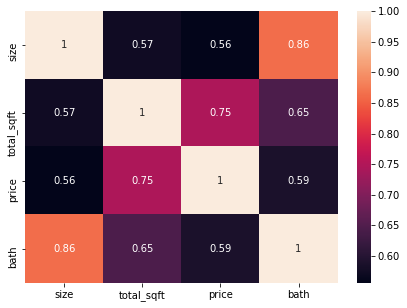

In [47]:
plt.figure(figsize=(7,5))
sns.heatmap(fil2[['size','total_sqft','price','bath']].corr(),annot=True)

<AxesSubplot:xlabel='total_sqft', ylabel='price'>

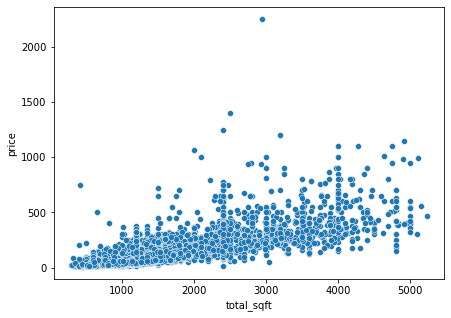

In [48]:
plt.figure(figsize=(7,5))
sns.scatterplot(x = 'total_sqft',y = 'price',data = fil2)

In [49]:
px.scatter(data_frame = fil2,x = 'size',y = 'total_sqft' )# some data have error

In [50]:
px.scatter(data_frame = fil,x = 'total_sqft',y = 'price' )

# Model and Feature Engineering

In [51]:
fil2.shape

(8836, 9)

In [52]:
fil2.drop_duplicates(inplace = True)

In [53]:
house3 = fil2.drop(['size_zscore','total_sqft_zscore','price_per_sqft','bath_zscore'],axis = 1)

In [54]:
house3.reset_index(drop=True,inplace = True)

In [55]:
house3 = house3.drop('price',axis = 1)

In [56]:
house3 = pd.get_dummies(house3,drop_first=True)

In [57]:
scaler = RobustScaler()

In [58]:
house3 = scaler.fit_transform(house3)

In [59]:
X = house3
y = np.log1p(fil2['price'])

In [60]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 5)

In [61]:
# Different models
models = {'XG_Boost':XGBRegressor(),
         'Linear':LinearRegression(),
         'Ridge':Ridge(alpha=0.005),
          'Gradient':GradientBoostingRegressor(n_estimators=300),
         'Random_Forest':RandomForestRegressor(n_estimators=200)}

In [62]:
for i in models:
    models[i].fit(X_train,y_train)
    pre_y = models[i].predict(X_test)
    
    print('################# {} ###################'.format(i))
    print('\n')
    print(i+'_MAE',mean_absolute_error(y_test,pre_y))
    print(i+'_MSE',mean_squared_error(y_test,pre_y))
    print(i+'_RMSE',(mean_squared_error(y_test,pre_y))**0.5)
    print(i+'R2_value',r2_score(y_test,pre_y))
    print('\n')

################# XG_Boost ###################


XG_Boost_MAE 0.20902017792411046
XG_Boost_MSE 0.08467378361979429
XG_Boost_RMSE 0.2909876004571231
XG_BoostR2_value 0.8388610508868005


################# Linear ###################


Linear_MAE 0.2348993744975509
Linear_MSE 0.1028833417109751
Linear_RMSE 0.32075433233391426
LinearR2_value 0.8042072427163258


################# Ridge ###################


Ridge_MAE 0.23489638682557196
Ridge_MSE 0.10287579751140156
Ridge_RMSE 0.3207425720284128
RidgeR2_value 0.8042215997503357


################# Gradient ###################


Gradient_MAE 0.2227157306243538
Gradient_MSE 0.08864980211115328
Gradient_RMSE 0.29774116630246694
GradientR2_value 0.8312944651744022


################# Random_Forest ###################


Random_Forest_MAE 0.20734331091111752
Random_Forest_MSE 0.09443391384522692
Random_Forest_RMSE 0.30730101504099677
Random_ForestR2_value 0.8202869768286934




In [63]:
param = {'learning_rate' : [0.01,0.05,0.1,0.2],
        'max_depth':[4,6,8,9],
        'gamma':[0,0.05,.1,.2,.3],
        'min_child_weight' : [5,7,8,10,],
        'colsample_bytree' : [0.55,0.65,0.75,0.85]}

In [64]:
XGBRegressor()

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

### HyperParameter tuning

In [66]:
ra_model = RandomizedSearchCV(XGBRegressor(),param_distributions= param)

In [67]:
ra_model.fit(X,y)

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                          reg_lambda=None,
     

In [68]:
ra_model.best_params_

{'min_child_weight': 10,
 'max_depth': 9,
 'learning_rate': 0.2,
 'gamma': 0.05,
 'colsample_bytree': 0.65}

In [69]:
ra_model.best_score_

0.8414920383914696

### Cross Validation

In [71]:
cv = cross_val_score(XGBRegressor(min_child_weight= 10, max_depth = 9,learning_rate= 0.2,gamma = 0.05,colsample_bytree = 0.65),X,y,cv = 10,n_jobs=4)

In [72]:
cv

array([0.86863484, 0.85533202, 0.85030081, 0.85898179, 0.83960211,
       0.79114406, 0.84790169, 0.84388293, 0.83243807, 0.83802261])

In [73]:
cv.max()# maximum score in CV

0.8686348425697521

In [74]:
cv.mean() # mean score of CV

0.8426240943632101

#### model with best parameters

In [82]:
model = XGBRegressor(min_child_weight= 10, max_depth = 9,learning_rate= 0.2,gamma = 0.05,colsample_bytree = 0.65)

In [83]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 5)

In [84]:
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.65, gamma=0.05, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=9,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [85]:
score = model.score(X_test,y_test)
score # score of the model for test data set

0.8436844876234411

In [92]:
print('Score of the model : ',score*100)

Score of the model :  84.3684487623441


In [79]:
pre_y = model.predict(X_test)

In [80]:
mean_absolute_error(y_test,pre_y)

0.20902017792411046

In [81]:
mean_squared_error(y_test,pre_y)

0.08467378361979429